# Exploring 311 dataset for department resource utilization

## Modelling

To understand and predict whether additional resources are required, we've approached in two ways
1) Regression
2) Classification

We have some pre-processing techniques involved in these two sections to additionally refine our dataset.

### Regression

In Regression,
we predict the **Resolution Time** for given 311 complaint record. We can further use rule base approach to identify whether this predicted resolution time would be above the average resolution time of that particular department, thus providing an insight into whether additional resources could be required for this complaint.

#### Pre-processing

In this section, we apply one hot encoding to convert categorical data into numerical data. 
Moreover, we also validate our target variable for only values greater than 0. As part of this section, we only retain the top 5
departments for which we want to predict.

To make a comparative study, we applied different regression models
1) Ridge Regression
2) ElasticNet Model
3) Random Forest Regressor
4) Gradient Boosting Regressor
5) XG Boost

In [23]:
# Importing all the necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import PercentFormatter
import random
import numpy as np
import matplotlib as mpl
import seaborn as sns
%matplotlib inline
plt.style.use(['fivethirtyeight'])
mpl.rcParams['lines.linewidth'] = 3

In [1]:

df_reg = pd.read_csv('311_preprocessed_dataset.csv')
df_reg = pd.get_dummies(df_reg, columns=['Agency','Complaint Type','Location Type','Address Type','City','Community Board','Borough','Open Data Channel Type'], dtype=int)


In [2]:
df_reg['Resolution Time'] = pd.to_timedelta(df_reg['Resolution Time'])

In [3]:
# Converting the 'Resolution Time' column into seconds from timedelta format
df_reg['Resolution Time'] = df_reg['Resolution Time'].dt.total_seconds()

In [4]:
#Checking if any rows with zero resolution time
count_zero_resolution_time = (df_reg['Resolution Time'] == 0.0).sum()

print(f"The number of rows with 'Resolution Time' equal to 0.0 is: {count_zero_resolution_time}")

The number of rows with 'Resolution Time' equal to 0.0 is: 6280


In [5]:
#Removing those rows with zero resolution time
df_reg = df_reg[df_reg['Resolution Time'] > 0.0]
df_reg = df_reg.reset_index(drop=True)
count_zero_resolution_time = (df_reg['Resolution Time'] == 0.0).sum()
count_zero_resolution_time

0

In [6]:
# Removing Unspecified BBL values
df_reg = df_reg[df_reg['BBL'] != 'Unspecified']
df_reg['BBL'] = df_reg['BBL'].astype('float')

In [7]:
# Scaling the column value to days by dividing it with 86400 seconds each day
df_reg['Resolution Time'] = df_reg['Resolution Time'] / 86400

In [8]:
#Fetching all the agencies
agency_columns = [col for col in df_reg.columns if col.startswith('Agency_')]

print("Columns starting with 'Agency_':")
print(agency_columns)

Columns starting with 'Agency_':
['Agency_3-1-1', 'Agency_DCA', 'Agency_DCWP', 'Agency_DEP', 'Agency_DEPARTMENT OF CONSUMER AND WORKER PROTECTION', 'Agency_DFTA', 'Agency_DHS', 'Agency_DOB', 'Agency_DOE', 'Agency_DOF', 'Agency_DOHMH', 'Agency_DOITT', 'Agency_DOT', 'Agency_DPR', 'Agency_DSNY', 'Agency_EDC', 'Agency_HPD', 'Agency_NYC311-PRD', 'Agency_NYPD', 'Agency_OTI', 'Agency_TLC']


In [9]:
#Choosing the top 5 agencies according to data analysis
agency_top_5 = ['Agency_HPD', 'Agency_NYPD', 'Agency_DSNY', 'Agency_DEP', 'Agnecy_DOB']

In [10]:
# Dropping the unnecessary departments from the dataset
columns_to_choose = [item for item in agency_columns if item not in agency_top_5]
df_reg = df_reg.drop(columns=columns_to_choose)

In [11]:
#Splitting data into training and testing
from sklearn.model_selection import train_test_split

y = df_reg["Resolution Time"]

X = df_reg.drop('Resolution Time', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X,y, test_size = 0.2, random_state = 42)

In [12]:
print(X_train.shape)
print(X_test.shape)

(178912, 522)
(44728, 522)


#### Ridge Regression

In [13]:
from sklearn.linear_model import Ridge
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

# Create a Ridge Regression model
ridge_model = Ridge(alpha=1.0)  # Using this alpha hyperparameter

ridge_model_pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('ridge', Ridge(alpha=1.0))
])

# Fit the model to the training data
ridge_model.fit(X_train, y_train)

# Make predictions on the test set
y_pred_ridge = ridge_model.predict(X_test)

# Evaluate the model
r2_ridge = r2_score(y_test, y_pred_ridge)

print(f'Ridge Regression - R^2 Score: {r2_ridge}')

C:\Users\sumed\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\linear_model\_ridge.py:200: LinAlgWarning: Ill-conditioned matrix (rcond=3.27141e-24): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge Regression - R^2 Score: 0.16806505650561865


#### ElasticNet Model

In [ ]:
from sklearn.linear_model import ElasticNet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Create and train the ElasticNet model over chosen hyperparameters
alpha = 0.5  # Regularization strength
l1_ratio = 0.5  # Mix ratio between L1 and L2 regularization
elastic_net = ElasticNet(alpha=alpha, l1_ratio=l1_ratio, random_state=42)
elastic_net.fit(X_train_scaled, y_train)

# Make predictions on the test set
y_pred = elastic_net.predict(X_test_scaled)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

#print the coefficients
print('Coefficients:', elastic_net.coef_)

#### Random Forest Regressor

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Create and train the Random Forest Regression model with chosen hyperparameters
random_forest = RandomForestRegressor(n_estimators=100, random_state=42)
random_forest.fit(X_train, y_train)

# Make predictions on the test set
y_pred = random_forest.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)

#### Gradient Boosting Regression

In [ ]:
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np

# Create and train the Gradient Boosting Regression model with chosen hyperparameters
gradient_boosting = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, random_state=42)
gradient_boosting.fit(X_train, y_train)

# Make predictions on the test set
y_pred = gradient_boosting.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)
print(f'R^2 Score: {r2}')

#### XGBoost

In [ ]:
import xgboost as xgb

# Create and train the XGBoost Regression model with chosen hyperparameters
xg_reg = xgb.XGBRegressor(objective ='reg:squarederror', colsample_bytree = 0.3, learning_rate = 0.1,
                max_depth = 5, alpha = 10, n_estimators = 100, random_state=42)

xg_reg.fit(X_train, y_train)

# Make predictions on the test set
y_pred = xg_reg.predict(X_test)

# Evaluate the model
r2 = r2_score(y_test, y_pred)

print(f'R^2 Score: {r2}')

### Classification

#### Pre-processing

In this section, we firstly create our target variable and then pre-process the dataset to refine it more.
In addition we also apply one hot encoding to convert the categorical values into numeric for modelling.

To make a comparative study, we applied different regression models
1) Decision Tree Classifier
2) Random Forest Classifier
4) Gradient Boosting Classifier
3) KNearest Neighbour Classifier

We chose the above models as they perform better on a combination of categorical and numeric data.

In [19]:
df_class = pd.read_csv('311_preprocessed_dataset.csv')

In [27]:
df_class.dtypes

POPULATION                     float64
Agency                          object
Complaint Type                  object
Location Type                   object
Address Type                    object
City                            object
Community Board                 object
BBL                            float64
Borough                         object
Open Data Channel Type          object
Latitude                       float64
Longitude                      float64
Resolution Time                float64
Created_Date_Year                int64
Created_Date_Month               int64
Created_Date_Day                 int64
Created_Date_Hour                int64
Created_Date_Minute              int64
Created_Date_Second              int64
AdditionalResourcesRequired      int64
dtype: object

##### Feature Engineering

Our target variable for classification
1) For the classification model, we created a new class label *Additional Resources Required*, which was derived from the *Resolution Time* attribute by considering department-wise the average resolution time, and labeled it as 1 if the *Resolution Time* was greater than the average, else we label it as 0.


In [20]:

def CreateAdditionalResourcesRequiredFeature(df):
    """ To create AdditionalResourcesRequired target variable for classification models  """
    df_agency = df.groupby('Agency')['Resolution Time'].mean()

    dict = {}
    for i in range(len(df_agency)):
        dict[df_agency.index[i]] = df_agency[i]
    print (dict)

    df['AdditionalResourcesRequired'] = -1
    for key in dict:
        df['AdditionalResourcesRequired'] = np.where(np.logical_and(df['Agency'] == key, df['Resolution Time'] >= dict[key]), 1, df['AdditionalResourcesRequired'])
    df['AdditionalResourcesRequired'] = np.where(df['AdditionalResourcesRequired'] != 1, 0, df['AdditionalResourcesRequired'])
    
    return df

def RemoveResolutionTimeOutliers(df):
    """ To remove Resolution Time outliers """
    departments = list(df['Agency'].unique())
    resolutionTimeMaxList = []
    for department in departments:
        # We remove extreme outliers from the dataset as it could influence our target variable creation
        # We remove the 90th percentile, as once we remove we can see the red plots on the graph which
        # are uniform when compared to blue plots which were before removing the outliers.
        df_temp = df[df['Agency'] == department]
        plt.scatter(df_temp.index, df_temp['Resolution Time'])
        print ("Removing 90th percentile outliers..")
        df_temp = df_temp[df_temp['Resolution Time'] < np.percentile(df_temp['Resolution Time'], 90)]
        plt.scatter(df_temp.index, df_temp['Resolution Time'], color='r')
        plt.xlabel('Unique Key')
        plt.ylabel('Resolution Time')
        resolutionTimeMaxList.append(df_temp['Resolution Time'].max())
        plt.show()

    for i in range(len(departments)):
        df['Resolution Time'] = np.where(np.logical_and(df['Agency'] == departments[i], df['Resolution Time'] > resolutionTimeMaxList[i]), np.timedelta64(-1), df['Resolution Time'])

    print ("Filtering out negative RT")
    df = df[df['Resolution Time'] > pd.Timedelta(0)]
    
    return df


In [21]:
# Filtering the departments out.
df_temp = df_class['Agency'].value_counts()
departments = list(df_temp.head(5).index)
df_class = df_class[df_class['Agency'].isin(departments)]

Removing 90th percentile outliers..


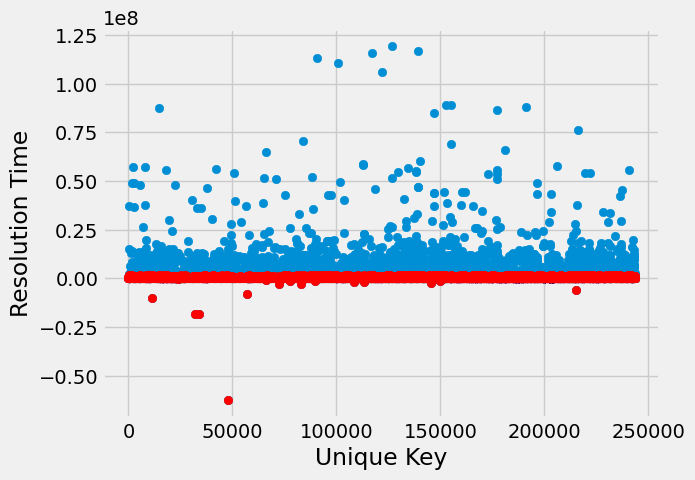

Removing 90th percentile outliers..


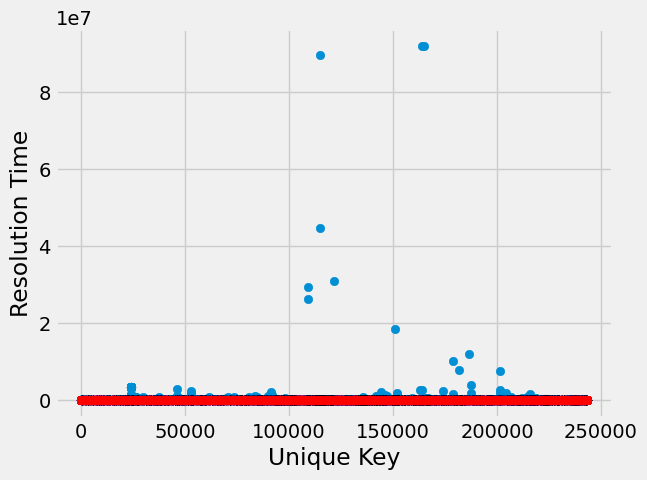

Removing 90th percentile outliers..


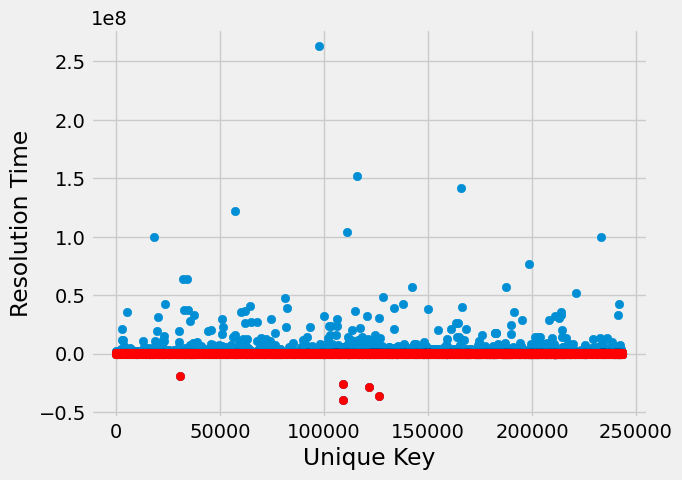

Removing 90th percentile outliers..


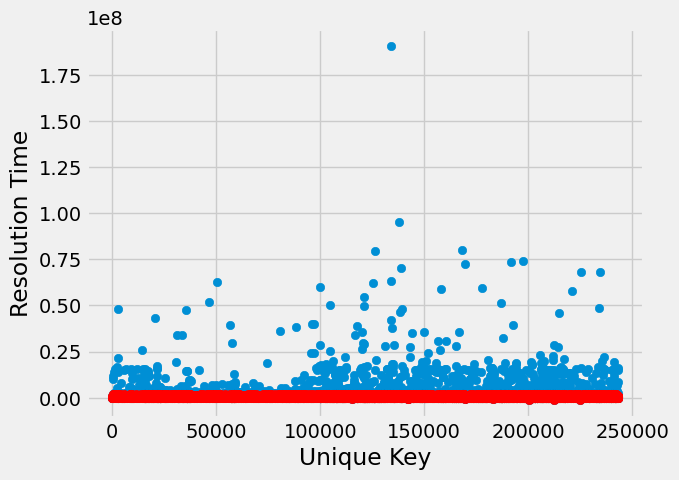

Removing 90th percentile outliers..


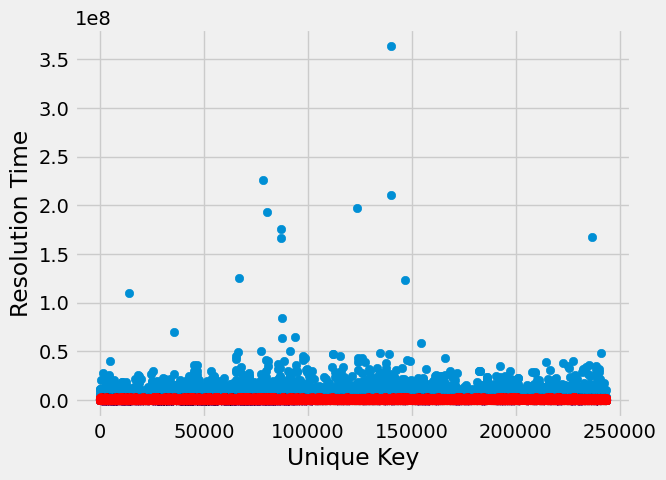

DTypePromotionError: The DType <class 'numpy.dtypes.TimeDelta64DType'> could not be promoted by <class 'numpy.dtypes.Float64DType'>. This means that no common DType exists for the given inputs. For example they cannot be stored in a single array unless the dtype is `object`. The full list of DTypes is: (<class 'numpy.dtypes.TimeDelta64DType'>, <class 'numpy.dtypes.Float64DType'>)

In [24]:
# Removing Resolution Time outliers for classification modelling as we are considering the mean
# for calculating the average resource required per department and the outliers would skew the results.
df_class = RemoveResolutionTimeOutliers(df_class)

In [25]:
# Removing Unspecified BBL values
df_class = df_class[df_class['BBL'] != 'Unspecified']
df_class['BBL'] = df_class['BBL'].astype('float')

C:\Users\sumed\AppData\Local\Temp\ipykernel_10604\3498070847.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_class['BBL'] = df_class['BBL'].astype('float')


In [26]:
# Creating target variable for classification task
df_class = CreateAdditionalResourcesRequiredFeature(df_class)

{'DEP': 531674.5100481177, 'DOT': 1217055.2480647746, 'DSNY': 1096258.2656862293, 'HPD': 1225284.1599573381, 'NYPD': 23564.253953571642}


C:\Users\sumed\AppData\Local\Temp\ipykernel_10604\710264361.py:7: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  dict[df_agency.index[i]] = df_agency[i]
C:\Users\sumed\AppData\Local\Temp\ipykernel_10604\710264361.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['AdditionalResourcesRequired'] = -1
C:\Users\sumed\AppData\Local\Temp\ipykernel_10604\710264361.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pa

In [28]:
# Removing Resolution Time column for classification dataset
df_class = df_class.drop(columns = ['Resolution Time'])

In [29]:
import pandas as pd

# Applying one-hot encoding to the dataset
df_class = pd.get_dummies(df_class, columns=['Agency','Complaint Type','Location Type','Address Type','City','Community Board','Borough','Open Data Channel Type'], dtype=float)

from sklearn.model_selection import train_test_split
Y = df_class['AdditionalResourcesRequired']
X = df_class.drop(columns = ['AdditionalResourcesRequired'])
df_train_X, df_test_X, df_train_Y, df_test_Y = train_test_split(X, Y, random_state=42, test_size=0.20)


#### Decision Tree Classifier

In [30]:
accuracy_scores = []
# Decision Tree
from sklearn.tree import DecisionTreeClassifier

# Creating the DecisionTreeClassifier instance
clf = DecisionTreeClassifier(criterion='gini', random_state=42, max_depth=13)
clf.fit(df_train_X, df_train_Y)

# Storing the predictions and accuracy scores for later evaluation to avoid later processing
accuracy_scores.append(clf.score(df_test_X, df_test_Y))
clf_pred = clf.predict(df_test_X)

#### Random Forest Classifier

In [32]:
# Random Forest Classifier
from sklearn.ensemble import RandomForestClassifier

# Creating the RandomForestClassifier instance to train the model
rfc = RandomForestClassifier(max_depth=13, random_state=42, max_features=None)
rfc.fit(df_train_X, df_train_Y)

# Storing the predictions and accuracy scores for later evaluation to avoid later processing
accuracy_scores.append(rfc.score(df_test_X, df_test_Y))
rfc_pred = rfc.predict(df_test_X)

In [ ]:
print (accuracy_scores)

#### Gradient Boosting Classifier

In [ ]:
# Gradient Boosting Classifier
from sklearn.ensemble import GradientBoostingClassifier

# Creating the GradientBoostingClassifier instance to train the model
gbc = GradientBoostingClassifier(n_estimators=1000, learning_rate=0.5, max_depth=1, random_state=42)
gbc.fit(df_train_X, df_train_Y)

# Storing the predictions and accuracy scores for later evaluation to avoid later processing
accuracy_scores.append(gbc.score(df_test_X, df_test_Y))
gbc_pred = gbc.predict(df_test_X)

#### KNN Classifier

In [ ]:
# KNN classifier
from sklearn.neighbors import KNeighborsClassifier

# Creating the KNNClassifier instance to train the model
knc = KNeighborsClassifier(n_neighbors=15)
knc.fit(df_train_X, df_train_Y)

# Storing the predictions and accuracy scores for later evaluation to avoid later processing
accuracy_scores.append(knc.score(df_test_X, df_test_Y))
knc_pred = knc.predict(df_test_X)

#### Evaluation Metrics

To evaluate our models, we perform a comprehensive analysis using different evaluation metrics. Here are the following metrics used

1) ROC AUC Curve
2) F1 Score
3) Accuracy
4) Precision
5) Recall
6) Confusion Matrix

With all the above metrics, we understand whether our model is performing on par expectations and what must be done to improve our modelling.

##### ROC AUC Curve

In [ ]:
from sklearn import metrics
import matplotlib.pyplot as plt 
def roc_curve(ytrue, ypred, model_name):
    """ To plot the AUC-ROC curve for all the models """
    fpr, tpr, thresholds = metrics.roc_curve(ytrue, ypred)
    auc = metrics.roc_auc_score(ytrue, ypred)
    plt.plot(fpr, tpr, label= model_name+' (AUC = %0.2f)' % auc)
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.0])
    plt.xlabel('FPR')
    plt.ylabel('TPR')
    plt.title('ROC')
    plt.legend(loc="lower right")

models = ['Decision Tree','Random Forest Classifier','Gradient Boosting Classifier','KNN Classifier']
def print_scores(table_scores):
    for i in range(len(models)):
        print (models[i] + " : %0.2f" % table_scores[i])

In [ ]:
# Plotting ROC AUC curves for all the models
roc_curve(df_test_Y, clf_pred, 'Decision Tree')
roc_curve(df_test_Y, rfc_pred, 'Random Forest Classifier')
roc_curve(df_test_Y, gbc_pred, 'Gradient Boosting Classifier')
roc_curve(df_test_Y, knc_pred, 'KNN Classifier')

##### F1 Score

In [ ]:
from sklearn.metrics import f1_score 
def F1_Score(ytrue, ypred):
    return f1_score(ytrue, ypred)

In [ ]:

# Printing the F1 scores for all the models
f1_table = []
f1_table.append(F1_Score(df_test_Y, clf_pred))
f1_table.append(F1_Score(df_test_Y, rfc_pred))
f1_table.append(F1_Score(df_test_Y, gbc_pred))
f1_table.append(F1_Score(df_test_Y, knc_pred))

print_scores(f1_table)

##### Accuracy

In [ ]:
# Printing the accuracy scores for all the models
print_scores(accuracy_scores)

##### Precision

In [ ]:
from sklearn.metrics import precision_score
def Precision(ytrue, ypred):
    return precision_score(ytrue, ypred)

# Printing the Precision scores for all the models
precision_table = []
precision_table.append(Precision(df_test_Y, clf_pred))
precision_table.append(Precision(df_test_Y, rfc_pred))
precision_table.append(Precision(df_test_Y, gbc_pred))
precision_table.append(Precision(df_test_Y, knc_pred))

print_scores(precision_table)

##### Recall

In [ ]:
from sklearn.metrics import recall_score
def Recall(ytrue, ypred):
    return recall_score(ytrue, ypred)

# Printing the Recall scores for all the models
recall_table = []
recall_table.append(Recall(df_test_Y, clf_pred))
recall_table.append(Recall(df_test_Y, rfc_pred))
recall_table.append(Recall(df_test_Y, gbc_pred))
recall_table.append(Recall(df_test_Y, knc_pred))

print_scores(recall_table)

##### Confusion Matrix

In [ ]:
from sklearn import metrics

preds = [clf_pred, rfc_pred, gbc_pred, knc_pred]

# Plotting the confusion matrix for all the models 
# to understand the bump on the graph.
for i in range(len(preds)):
    confusion_matrix = metrics.confusion_matrix(df_test_Y, clf_pred)

    cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])
    
    cm_display.plot()
    plt.title(models[i])
    plt.show()

In [ ]:
# Random Forest Classifier
'''confusion_matrix = metrics.confusion_matrix(df_test_Y, rfc_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()'''

In [ ]:
'''confusion_matrix = metrics.confusion_matrix(df_test_Y, clf_pred)

cm_display = metrics.ConfusionMatrixDisplay(confusion_matrix = confusion_matrix, display_labels = [False, True])

cm_display.plot()
plt.show()'''